# Checkpoint 2: Mandatory Check-In

- Research Questions (1.5%).
- Feature Engineering (2%).
- Modeling Approaches (3%).
- Preliminary Results (1%).


## Import data

In [1]:
import zipfile
import numpy as np
import re
import io
from tqdm import tqdm
import pandas as pd

In [2]:
!ls ../Data

README.md  sp24_grad_project_data  sp24_grad_project_data.zip


In [33]:
 def read_files_from_zip(zip_file_path, regex_pattern):
    """
    This function reads files from a zip file that matches a given regex pattern.
    It assumes the regex pattern contains two groups (train|test) and a nominative group (some_name).
    
    Parameters:
    zip_file_path (str): The path to the zip file.
    regex_pattern (str): The regex pattern to match the files.

    Returns:
    dict: A dictionary with the name as key, and a sub-dictionary of type and file as values.
    """
    data_dict = {}  # Dictionary with name as key, and sub-dict of type and file as value

   # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # List all files
        all_files = zip_ref.namelist()

        # Filter files based on the regex pattern and create a dictionary
        for file in all_files:
            match = re.search(regex_pattern, file)
            if match:
                filtered = list(match.groups())
                data_type = [s for s in filtered if re.search(r'(test|train)', s)][0]
                filtered.remove(data_type)
                data_name = filtered[0]
                data_dict[data_name] = {'type':data_type, 'file':file}

        # Read in the data for each file
        for name in tqdm(data_dict.keys(), ascii=False, desc=f"Importing data from zip"):         
            with zip_ref.open(data_dict[name]['file']) as f:
                bytes_io = io.BytesIO(f.read())
                data_dict[name]['data'] = np.load(bytes_io, allow_pickle=True)
    print('Found the following datasets: ', list(data_dict.keys()))
    return data_dict

# Set Date Source
data_file = '../Data/sp24_grad_project_data.zip'

# Load Test Images
test_data_images = read_files_from_zip(data_file, r'(test)_images_([\w-]*)\.npz')

# Load Train Images and Labels
train_data_images = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_images\.npz')
train_data_labels = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_labels\.npy')

Importing data from zip: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Found the following datasets:  ['hurricane-matthew', 'flooding-fire']


Importing data from zip: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']


Importing data from zip: 100%|██████████| 3/3 [00:00<00:00, 1868.84it/s]

Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']


In [48]:
name = 'socal-fire'
train_labels = train_data_labels[name]['data']
train_images = [image[1] for image in tqdm(train_data_images[name]['data'].items())]
assert (train_labels.shape[0]==len(train_images))

100%|██████████| 8380/8380 [00:03<00:00, 2464.99it/s]


(153, 150, 3)

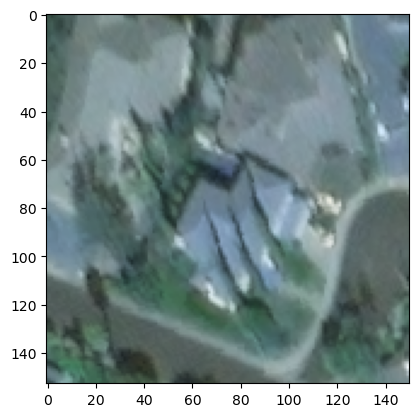

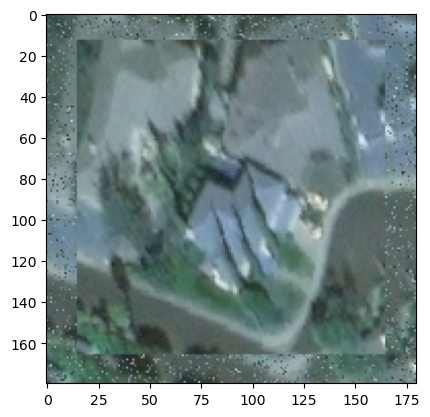

In [147]:
import cv2
import numpy as np


def crop_and_fill(image, N, background='black', replace_scaled=0):
    """
    This function takes an image and a crop size as input, and returns a cropped image.
    The cropping behavior depends on the size of the input image relative to the crop size.
    The background of the output image can be either black or a scaled version of the input image.
    If replace_scaled is a probability between 0 and 1, a proportion of the scaled background will be replaced with pixels from the original image.

    Parameters:
    image (numpy.ndarray): The input image, a numpy array of shape (n, m, 3).
    N (int): The desired crop size.
    background (str): The type of background for the output image. Can be either 'black' or 'scaled'.
    replace_scaled (float): The probability of replacing each pixel in the scaled background with a pixel from the original image.

    Returns:
    numpy.ndarray: The cropped image, a numpy array of shape (N, N, 3).
    """
    n, m, _ = image.shape
    if background == 'scaled':
        output = cv2.resize(image, (N, N))
        if replace_scaled > 0:
            indices = np.random.choice(np.arange(N*N), replace=True, size=int(replace_scaled*N*N)) 
            flat_indices = np.random.choice(np.arange(n*m), replace=True, size=len(indices))
            row_indices = flat_indices // m  # convert to row indices
            col_indices = flat_indices % m  # convert to column indices
            replacements = image[row_indices, col_indices].reshape(-1, 3)  # use 2D indices
            output.reshape(-1, 3)[indices] = replacements
    else:
        output = np.zeros((N, N, 3), dtype=image.dtype)

    if n > N and m > N:
        x = np.random.randint(0, n - N)
        y = np.random.randint(0, m - N)
        output = image[x:x+N, y:y+N]

    elif n < N and m < N:
        x = (N - n) // 2
        y = (N - m) // 2
        output[x:x+n, y:y+m] = image

    else:
        if n < N:
            x = (N - n) // 2
            y = np.random.randint(0, m - N)
            output[x:x+n, :] = image[:, y:y+N]
        else:
            x = np.random.randint(0, n - N)
            y = (N - m) // 2
            output[:, y:y+m] = image[x:x+N, :]

    black_pixels = np.where(np.all(output == [0, 0, 0], axis=-1))
    non_black_pixels = np.where(np.any(image != [0, 0, 0], axis=-1))
    replacements = image[non_black_pixels]
    np.random.shuffle(replacements)
    replacements = np.repeat(replacements, np.ceil(len(black_pixels[0]) / len(replacements)), axis=0)
    output[black_pixels] = replacements[:len(black_pixels[0])]

    return output

image_array = train_images[5]
cropped_image = crop_and_fill(image_array, 180, background='scaled', replace_scaled=0.2)
from eda_utils import show_image

display(image_array.shape)
show_image(image_array)
plt.show()
show_image(cropped_image)
plt.show()

In [110]:

"""
def create_df(train_images, train_labels=None):
    frames = []
    for name in train_images.keys():
        df = pd.DataFrame()
        if train_labels != None:
            df['label'] = train_labels[name]['data']
        df['image'] = [image[1] for image in tqdm(train_images[name]['data'].items(), desc=f"Converting to DataFrame: {name}")]
    
        df['name'] = name
        regex = r'(?:fire|flood|hurricane)'
        matches = re.findall(r'(fire|flood|hurricane)', name)
        type = matches[0] if matches else None
        df['type'] = type
        
        frames.append(df)    
    return pd.concat(frames)

print("Train:")
df_train = create_df(train_images, train_labels)
print("Test:")
df_test = create_df(test_images)
""";

# think about this more